# Burgers' equation

Next we'll look at the non-linear PDE 

$${\partial f\over \partial t} + f{\partial f\over \partial x} = D {\partial^2 f\over \partial x^2}$$

which is known as the **viscous Burgers' equation**. It comes up in fluids, where $f=u$, the fluid velocity, and traffic modelling as well as other situations.

The non-linearity introduces a coupling between modes. Using the inverse Fourier transform

$$f(x) = {1\over 2\pi} \int dk\ g(k) e^{ikx}$$

(where the normalization matches the `numpy.fft` convention), the non-linear term is

$$f{\partial f\over \partial x} = {1\over (2\pi)^2} \int dk^\prime dk^{\prime\prime} g(k^\prime) g(k^{\prime\prime}) ik^{\prime\prime} e^{i(k^\prime+k^{\prime\prime})x}$$

Now multiply this by 

$$\int dk\ e^{ikx}$$ 

which will extract the $k$-component:

$${1\over (2\pi)} \int dk^\prime dk^{\prime\prime} g(k^\prime) g(k^{\prime\prime}) ik^{\prime\prime} \delta(k^\prime + k^{\prime\prime} - k)$$

$$ = {1\over 2\pi} \int dk^\prime g(k^\prime) g(k-k^\prime) i (k-k^\prime).$$

Adding this to the diffusion part we had last time, we get

$${dg(k)\over dt} = - Dk^2 g(k) - {1\over 2\pi} \int dk^\prime g(k^\prime) g(k-k^\prime) i (k-k^\prime).$$


When we implement this using the discrete Fourier transform, we have to be careful to include only the modes that we have available to us (within the Nyquist frequency). There is a nice implementation of this here:

https://kth-nek5000.github.io/kthNekBook/_notebooks/burgers.html

which uses the shifted version of the FFT to simplify the calculation, which I've implemented below:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg

In [2]:
def do_integration(f_init, dt, n, dx, D, T, make_plot = False):
    
    if make_plot:
        %matplotlib

    g = np.fft.fft(f_init)
    g = np.fft.fftshift(g)
    k = np.fft.fftfreq(n)
    k = np.fft.fftshift(k)

    K = n//2-1
    kk=range(-K,K+1)
    
    nsteps = int(T/dt)
    dt = T/nsteps  # make sure we end at the required time t=T

    for i in range(nsteps):
        
        dg = np.zeros_like(g)
        
        # use the approach from
        # https://kth-nek5000.github.io/kthNekBook/_notebooks/burgers.html
        for l_ in kk:
            for k_ in kk:
                m_=l_-k_
                if abs(m_)<=K:
                    dg[l_+n//2] += -1j * m_ * g[k_+n//2] * g[m_+n//2] * dx

        # diffusion term
        dg += - D*k*k * (2*np.pi/dx)**2 * g
        
        g = g + dt*dg
        
        if make_plot:
            if True: #(i % (nsteps//(10*T)) == 0) or (i == (nsteps-1)):
                f = np.fft.ifft(np.fft.ifftshift(g))
                plt.clf()
                plt.plot(x,f_init, ":", lw=2)
                plt.plot(x,f)
                plt.title('t=%.3lg' % ((i+1) * T/nsteps))
                plt.pause(1e-3)
    
    if make_plot:
        plt.close()
        %matplotlib inline

    return np.fft.ifft(np.fft.ifftshift(g))   


We can repeat this but using a convolution to evaluate the non-linear term:

In [3]:
def convolution(f,g):
    ft = np.fft.fft(f)
    gt = np.fft.fft(g)
    return np.fft.ifft(ft*gt)

In [4]:
def do_integration_convolve(f_init, dt, n, dx, D, T, make_plot = False):
    
    if make_plot:
        %matplotlib

    g = np.fft.fft(f_init)
    k = np.fft.fftfreq(n)
    
    nsteps = int(T/dt)
    dt = T/nsteps  # make sure we end at the required time t=T

    for i in range(nsteps):
        
        # do the non-linear term with a convolution
        dg = -convolution(g, 1j * k*g)
        
        # can also include a constant advection velocity if we want
        V = 1
        dg += -1j * k * V * g
        
        # diffusion term
        dg += - D*k*k * (2*np.pi/dx)**2 * g
        
        g = g + dt*dg
        
        if make_plot:
            if True: #(i % (nsteps//(10*T)) == 0) or (i == (nsteps-1)):
                f = np.fft.ifft(g)
                plt.clf()
                plt.plot(x,f_init, ":", lw=2)
                plt.plot(x,f)
                plt.title('t=%.3lg' % ((i+1) * T/nsteps))
                plt.pause(1e-3)
    
    if make_plot:
        plt.close()
        %matplotlib inline

    return np.fft.ifft(g)

In [5]:
def plot_grid(do_integration, T, title):
    
    plt.clf()
    plt.figure(figsize = (10,3))
    plt.suptitle(title)

    plt.subplot(131)
    D, dt = 1e-6, 0.01
    f = do_integration(f_init, dt, n, dx, D, T)
    plt.title('T=%lg, D=%.1e, dt=%lg' % (T, D, dt))
    plt.plot(x, f_init, ":", lw=2)
    plt.plot(x, f)

    plt.subplot(132)
    D, dt = 1e-4, 0.01
    f = do_integration(f_init, dt, n, dx, D, T)
    plt.title('T=%lg, D=%.1e, dt=%lg' % (T, D, dt))
    plt.plot(x, f_init, ":", lw=2)
    plt.plot(x, f)

    plt.subplot(133)
    D, dt = 1e-2, 0.001
    f = do_integration(f_init, dt, n, dx, D, T)
    plt.title('T=%lg, D=%.1e, dt=%lg' % (T, D, dt))
    plt.plot(x, f_init, ":", lw=2)
    plt.plot(x, f)

    plt.tight_layout()
    plt.show()


/opt/homebrew/lib/python3.11/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


<Figure size 640x480 with 0 Axes>

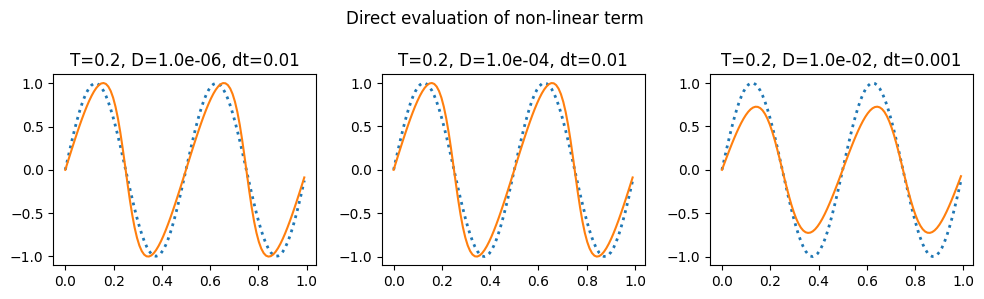

<Figure size 640x480 with 0 Axes>

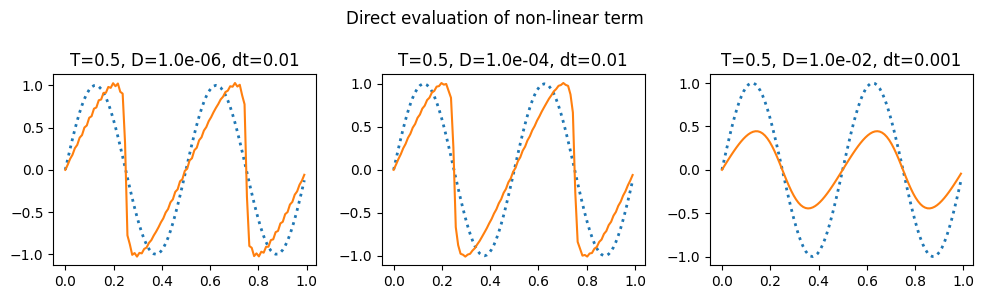

<Figure size 640x480 with 0 Axes>

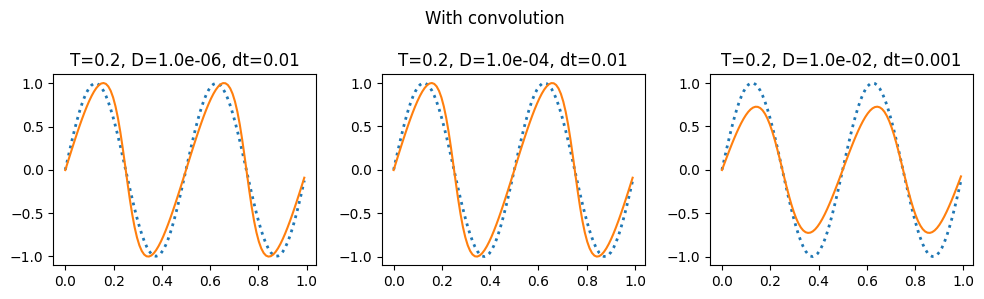

<Figure size 640x480 with 0 Axes>

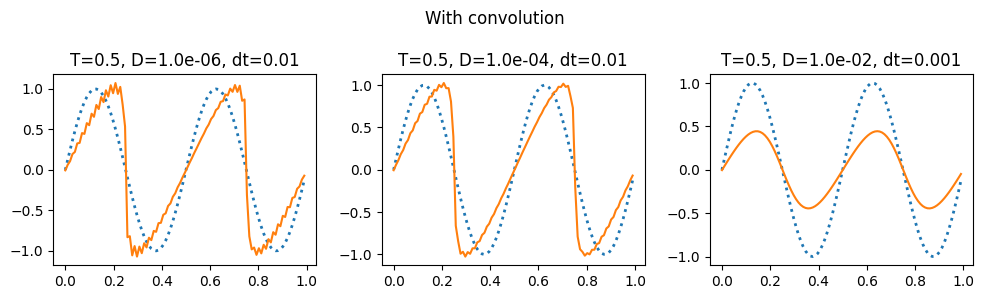

In [6]:
# set up the grid
n = 101
x = np.linspace(0, 1, n, endpoint=False)
dx = x[1]-x[0]

f_init = np.sin(2*np.pi*x * 2)

plot_grid(do_integration, 0.2, 'Direct evaluation of non-linear term')
plot_grid(do_integration, 0.5, 'Direct evaluation of non-linear term')
plot_grid(do_integration_convolve, 0.2, 'With convolution')
plot_grid(do_integration_convolve, 0.5, 'With convolution')


## Further reading

- The notes linked to above have a discussion of the aliasing errors that happen when taking the convolution and the ways to eliminate them (2/3 rule and 3/2 rule):    https://kth-nek5000.github.io/kthNekBook/_md/spectral/pseudo.html. You can see above that we get a much better result when evaluating the double sum directly than when using the convolution function.